# Kunden-Clustering

Im letzten Kapitel beschäftigen wir uns mit sogenannter Customer Segmentation.

Wenn wir Marketingmassnahmen planen, sollten wir verstehen, wer unsere Kunden sind. Häufig gibt es aber nicht nur einen Kundentypen, sondern mehrere unterschiedliche (mit unterschiedlichen Merkmalen).

Wir möchten diese Kundengruppen gerne trennen, damit wir möglicht massgeschneiderte Marketingmassnahmen planen können.

Für dieses Kapitel verwenden wir einen Datensatz von kaggle, welcher hier abgelegt ist: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

In [7]:
#importing libraries and setting the working directory
%pip install yellowbrick

#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

#own imports
import sys
import os

# Get the current script's directory
notebook_path = os.path.dirname(os.path.abspath("__file__"))

# Add the parent directory to sys.path
parent_dir = os.path.dirname(notebook_path)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now you should be able to import your module
import fhnw_colourmap


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Laden des Datensatzes

Wir laden den entsprechenden Datensatz. 

In [8]:
#Loading the dataset
# Load the data without processing quotes
data = pd.read_csv("data/marketing_campaign.csv", sep='\t', quoting=3)  # 3 is the code for csv.QUOTE_NONE

# Strip quotes from all string columns
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].str.strip('"')

#rename column names
data = data.rename(columns = {
    '"ID': "ID",
    'Response"': "Response",
})

print(data.head())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

## Data cleaning

In dieser Applikation nehmen wir noch etwas Data cleaning vor. Wir gehen wie folgt vor.

In [9]:
#get overview of features and their type  
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   object 
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Wir sehen hier Folgendes:
- Income hat fehlende Angaben
- es gibt kategoriale und numerische Variablen, diese müssen wir später passend verarbeiten
Wir eliminieren Beobachtungen, bei denen Werte "NA" sind:

In [10]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216




## Generierung von interessanten Variablen

Für die Analyse generieren wir zwei zusätzliche Variablen:
- "Dt_Customer": Die Anzahl Tage, die ein Kunde in der Unternehmensdatenbank registriert ist.
- "Customer_For": Anzahl Tage, nachdem der Kunde angefangen hat, im Shop Dinge einzukaufen, realtiv zum letzten verzeichneten Datum. 

In [11]:
#Feature "Dt_Customer"
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format='%d-%m-%Y')
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


## Feature Engineering

Wir bearbeiten einige Variablen, damit wir sie besser bearbeiten können. Wir nehmen folgende Anpassungen vor:

- Ermitteln des Alters eines Kunden anhand von "Year_Birth", welches das Geburtsjahr der jeweiligen Person angibt.
- Weiteres Merkmal "Spent", welches die Gesamtausgaben des Kunden in verschiedenen Kategorien über einen Zeitraum von zwei Jahren angibt.
- Aus dem Merkmal "Marital_Status" ein weiteres Merkmal "Living_With", um die Wohnsituation von Paaren zu ermitteln.
- Weiteres Merkmal "Children", um die Gesamtzahl der Kinder in einem Haushalt anzugeben.
- Merkmal, welches die "Family_Size" (Familiengröße) angibt.
- Dummy-Merkmal "Is_Parent", um den Elternstatus anzuzeigen.
- Drei Kategorien des Merkmals "Education", um die Zählung zu vereinfachen.
- Entfernung einiger redundanter Merkmale

In [12]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

# Überblick über das angepasste Datenset

Wir haben nun einige Variablen verändert oder kreiert und möchten gernen den neuen Datensatz anschauen.

In [13]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.073105,0.064079,0.013538,0.009477,3.054423e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.260367,0.244950,0.115588,0.096907,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


# Datenvisualisierung

<Figure size 432x288 with 0 Axes>

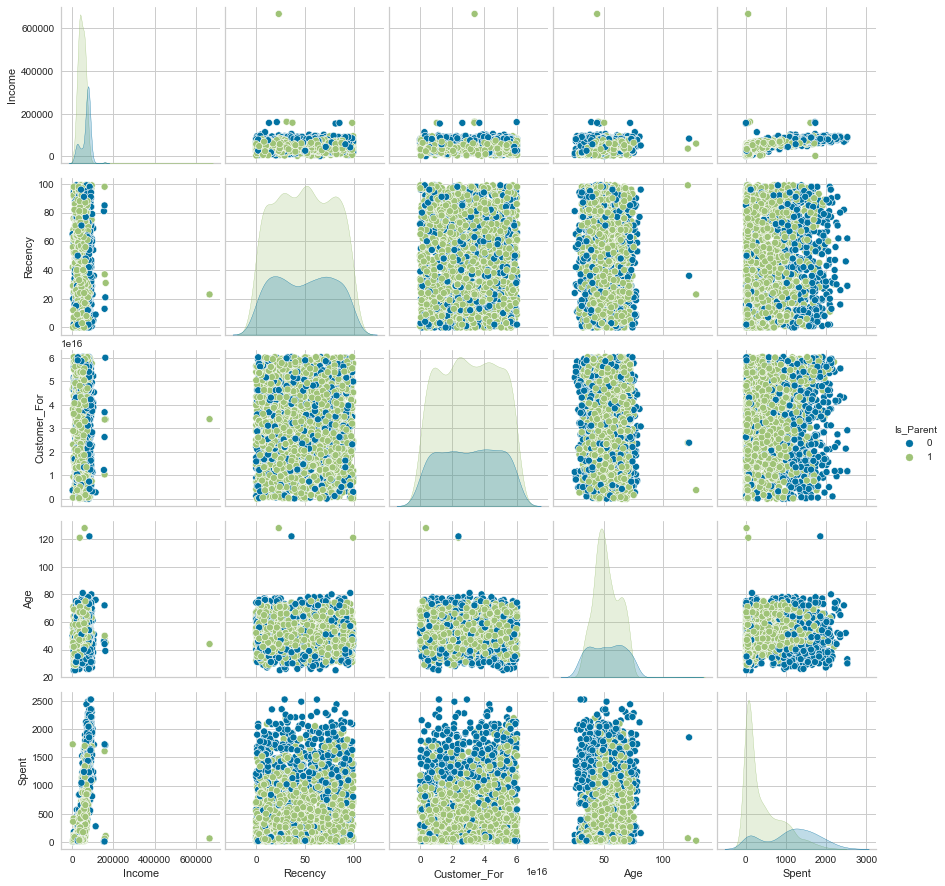

In [14]:
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent")
#Taking hue 
plt.show()

# Korrelationsanalyse

Wir möchten in einem nächsten Schritt herausfinden, inwiefern die daten miteinander korrelieren. Kategoriale Merkmale werden hier nicht berücksichtigt.

#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

## Data Preprocessing

Wir wenden nun folgende Schritte an, um die Daten zu verarbeiten und für unsere Clustering-Methoden geeignet zu machen.

- Label Encoding für kategoriale Variablen
- Skalierung der Merkmale mithilfe eines Standardscalers
- Kreation einens Subsets für dimensionsreduzierende Verfahren

In [15]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

#label encoding
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

#copy of the dataframe
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

#scaled data used for dimensionality reduction
print("Dataframe to be used for further modelling:")
scaled_ds.head()

All features are now numerical
All features are now scaled
Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.894187,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,...,2.504712,-0.554143,0.693232,1.529129,0.986443,1.675488,-1.348829,-1.264803,-1.758673,-1.581389
1,-0.894187,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,...,-0.571082,-1.169518,-0.131574,-1.188411,1.236801,-0.962358,-1.348829,1.405806,0.450009,0.632356
2,-0.894187,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,...,-0.229327,1.291982,-0.543978,-0.205155,0.318822,0.280250,0.741384,-1.264803,-0.654332,-1.581389
3,-0.894187,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,...,-0.912837,-0.554143,0.280829,-1.059945,-1.266777,-0.919224,0.741384,0.070501,0.450009,0.632356
4,0.569268,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,...,0.112428,0.061232,-0.131574,-0.951244,-1.016420,-0.307044,0.741384,0.070501,0.450009,0.632356


## Dimensionsreduzierende Verfahren
Dieser Datensatz hat sehr viele Merkmale. Viele Merkmale bedeuten für Machine Learning-Algorithmen immer, dass die Rechenzeit zunimmt. Deshalb versuchen wir jetzt, die Anzahl der Merkmale zu reduzieren. Wir führen hierfür eine sogenannte Principal Component Analysis (PCA) durch. 

Wir möchten gerne 3 Dimensionen haben, damit wir die Kunden im dreidimensionalen Raum visualieren können.

In [16]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2216.0,1.923852e-17,2.850029,-5.881402,-2.489399,-0.795923,2.428344,7.390968
col2,2216.0,-6.412841e-17,1.701845,-4.169995,-1.317372,-0.186315,1.232900,6.140593
col3,2216.0,1.683371e-17,1.228077,-5.051220,-0.845780,-0.048606,0.866476,6.713941


Jetzt können wir die Kunden graphisch darstellen.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


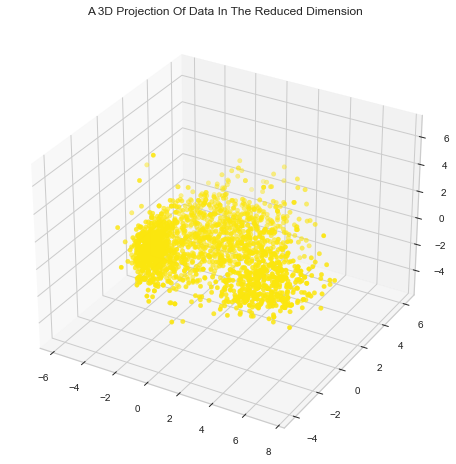

In [17]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c=fhnw_colourmap.fhnw_colour, marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Clustering

Da wir nun die Anzahl der Dimensionen reduziert haben, können versuchen, die Kundengruppen zu clustern.

Elbow Method to determine the number of clusters to be formed:


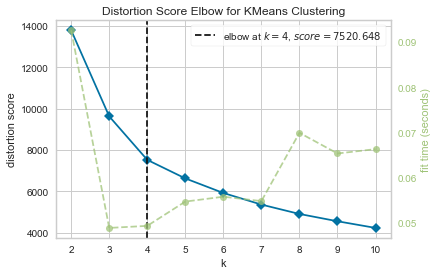

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# Quick examination of elbow method to find numbers of clusters to make.
# from yellowbrick.cluster import KElbowVisualizer

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

Wir sehen, dass die optimale Anzahl der Cluster (=Gruppen) somit 4 beträgt. Somit versuchen wir nun, die Gruppen zu bestimmen und etwas genauer zu analysieren. 

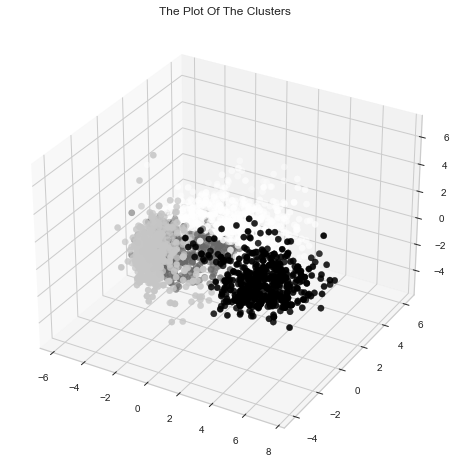

In [19]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

## Modelevaluation

Da die Gruppen jetzt gebildet sind, können wir analysieren, welche Charakteristiken die Gruppen aufweisen. 

Als Erstes schauen wir uns die Gruppengrösse an.

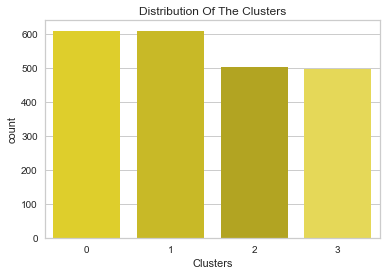

In [28]:
#Plotting countplot of clusters
import fhnw_colourmap
pal = fhnw_colourmap.hex_colors[:4]
pl = sns.countplot(x=data["Clusters"], palette = pal)
pl.set_title("Distribution Of The Clusters",)
plt.show()

Als Nächstes analysieren die Gruppen basierend auf Einkommen (Lohn) sowie den Ausgaben im Shop. 

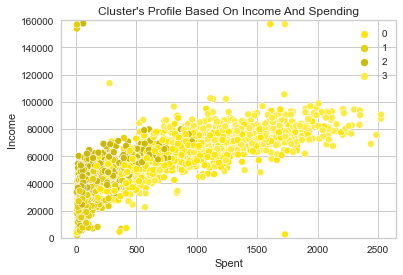

In [30]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.ylim(0, 160000)  # Replace min_y_value and max_y_value with your desired limits


plt.show()